## Importation des librairies et des données

In [38]:
# Importation des librairies
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prétraitement et visualisation
## Importation des données

In [2]:
# Importation des données
file_path = "data/Star39552_balanced.csv"
data = pd.read_csv(file_path)

In [3]:
# Visualisation des données
data

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,10.00,31.66,6.19,1.213,K7V,22.502556,1
1,8.26,3.21,1.00,1.130,K0III,15.792525,0
2,8.27,12.75,1.06,0.596,F9V,18.797552,1
3,6.54,5.23,0.76,1.189,K1III,15.132508,0
4,8.52,0.96,0.72,0.173,B8V,13.431356,1
...,...,...,...,...,...,...,...
39547,5.83,0.17,0.52,0.474,B7Iab,6.982245,0
39548,7.05,18.12,0.92,0.424,F5V,18.340790,1
39549,9.21,3.89,1.46,0.227,A1IV,17.159748,1
39550,9.01,2.13,1.46,1.467,M5III,15.651898,0


Les données représentes différentes caractéristiques et une classification d'étoiles observées. Elles comportent 39'552 observations et 7 variables

**Variables** :
- **Vmag** (numérique) : Magnitude apparente de l’étoile
- **Plx** (numérique) : Distance entre l’étoile et la Terre
- **e_Plx** (numérique) : Erreur type de Plx
- **B-V** (numérique) : Indice couleur B-V
- **SdType** (catégorielle) : Type spectral
- **Amag** (numérique) : Magnitude absolue de l’étoile
- **TargetClass** (catégorielle) : 0 pour naine, 1 pour géante

La variable à prédire est la "TargetClass", le but est de pouvoir déterminer si une étoile est naine ou géante en fonction des autres variables

**Source:**
Wing-Fung Ku. (2020). *Star Dataset for Stellar Classification* [Data set]. Kaggle. [https://doi.org/10.34740/KAGGLE/DSV/1433961](https://doi.org/10.34740/KAGGLE/DSV/1433961)

In [4]:
# Vérification si valeurs manquantes
data.isnull().values.any()

False

In [5]:
# Enlver les lignes avec une erreur (e_Plx) trop grande
data = data[data['e_Plx'] < 1]
data.shape
data['TargetClass'].value_counts()

TargetClass
0    11328
1     8883
Name: count, dtype: int64

## Séparation des données en entrées et sortie

In [6]:
# Séparation des données en entrées et sortie
# Entrées
X = data.drop(['TargetClass', 'e_Plx'], axis = 1)
print(X)

# Sorties
y = data['TargetClass']
print(y)

       Vmag    Plx    B-V SpType       Amag
3      6.54   5.23  1.189  K1III  15.132508
4      8.52   0.96  0.173    B8V  13.431356
5      6.09   6.02  0.040  B8IVn  14.987983
6      7.94   5.36  1.066  K0III  16.585825
8      7.68   0.66  0.013  B2V:e  11.777719
...     ...    ...    ...    ...        ...
39545  7.86   1.58  1.341  K2III  13.853286
39546  8.36   2.44  1.087  K1III  15.296949
39547  5.83   0.17  0.474  B7Iab   6.982245
39548  7.05  18.12  0.424    F5V  18.340790
39551  9.12   3.82  0.480    F5V  17.030317

[20211 rows x 5 columns]
3        0
4        1
5        1
6        0
8        1
        ..
39545    0
39546    0
39547    0
39548    1
39551    1
Name: TargetClass, Length: 20211, dtype: int64


## Encodage de la variable HarvardType

In [7]:
X['SpType'].value_counts()

SpType
K0III           1482
K1III            917
K2III            836
G8III            783
K3III            682
                ... 
A5Ia               1
K3Ib comp SB       1
WC8 + O9I          1
K3II+...           1
B9II-III           1
Name: count, Length: 1761, dtype: int64

Le type spectral (SpType) comporte 1761 instances différentes, ce qui donnera trop de variable en utilisant un *One Hot Encoder*, il faut séparer les compsantes de la *Harvard spectral classification* : la première composante est la première lettre qui représente le type d'étoile, la deuxième composante est un nombre entre 0 et 9 qui représente les subdivions du type (en focntion de la température). Plus d'inforamtion sur la classifiaction spectral peuvent être trouvé sur [la page wikipedia du type spectral](https://fr.wikipedia.org/wiki/Type_spectral)

In [8]:
# Simplification de la variable SpType
# Harvard Type
X['HarvardType'] = X['SpType'].str[0] # Extraire premier caractère
print(X['HarvardType'].value_counts())

# Harvard Sub Type
X['HarvardSubType'] = X['SpType'].apply(lambda x: int(re.search(r'\d', x).group()) if re.search(r'\d', x) else None) # Extraire le premier chiffre
X['HarvardSubType'] = X['HarvardSubType'].fillna(X['HarvardSubType'].mean()) # Remplacer les valeurs manquantes par la moyenne
print(X['HarvardSubType'].value_counts())

X = X.drop(['SpType'], axis = 1)

HarvardType
K    6614
F    3237
G    3225
B    3184
A    2758
M    1124
O      48
C      19
W       2
Name: count, dtype: int64
HarvardSubType
0.000000    3740
2.000000    2947
8.000000    2609
3.000000    2456
1.000000    2372
5.000000    1998
9.000000    1290
4.000000    1046
6.000000     997
7.000000     743
3.637637      13
Name: count, dtype: int64


In [9]:
# Encodage de la variable HarvardType
encoder_onehot = OneHotEncoder(dtype = 'int')
type_encoded = encoder_onehot.fit_transform(X[['HarvardType']]).toarray()
type_encoded_df = pd.DataFrame(type_encoded, columns=encoder_onehot.get_feature_names_out(['HarvardType']))

X.reset_index(drop=True, inplace=True)

X = pd.concat([X, type_encoded_df], axis=1)
X= X.drop(['HarvardType'], axis = 1)
X

,Vmag,Plx,B-V,Amag,HarvardSubType,HarvardType_A,HarvardType_B,HarvardType_C,HarvardType_F,HarvardType_G,HarvardType_K,HarvardType_M,HarvardType_O,HarvardType_W
0,6.54,5.23,1.189,15.132508,1.0,0,0,0,0,0,1,0,0,0
1,8.52,0.96,0.173,13.431356,8.0,0,1,0,0,0,0,0,0,0
2,6.09,6.02,0.040,14.987983,8.0,0,1,0,0,0,0,0,0,0
3,7.94,5.36,1.066,16.585825,0.0,0,0,0,0,0,1,0,0,0
4,7.68,0.66,0.013,11.777719,2.0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20206,7.86,1.58,1.341,13.853286,2.0,0,0,0,0,0,1,0,0,0
20207,8.36,2.44,1.087,15.296949,1.0,0,0,0,0,0,1,0,0,0
20208,5.83,0.17,0.474,6.982245,7.0,0,1,0,0,0,0,0,0,0
20209,7.05,18.12,0.424,18.340790,5.0,0,0,0,1,0,0,0,0,0


In [10]:
X.isnull().values.any()
null_mask = X.isnull().any(axis=1)
null_rows = X[null_mask]
print(null_rows)

Empty DataFrame
Columns: [Vmag, Plx, B-V, Amag, HarvardSubType, HarvardType_A, HarvardType_B, HarvardType_C, HarvardType_F, HarvardType_G, HarvardType_K, HarvardType_M, HarvardType_O, HarvardType_W]
Index: []


## Standardisation des données

In [11]:
# Standardisation des données
X = StandardScaler().fit_transform(X)

## Visualisation des données
### PCA

In [12]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


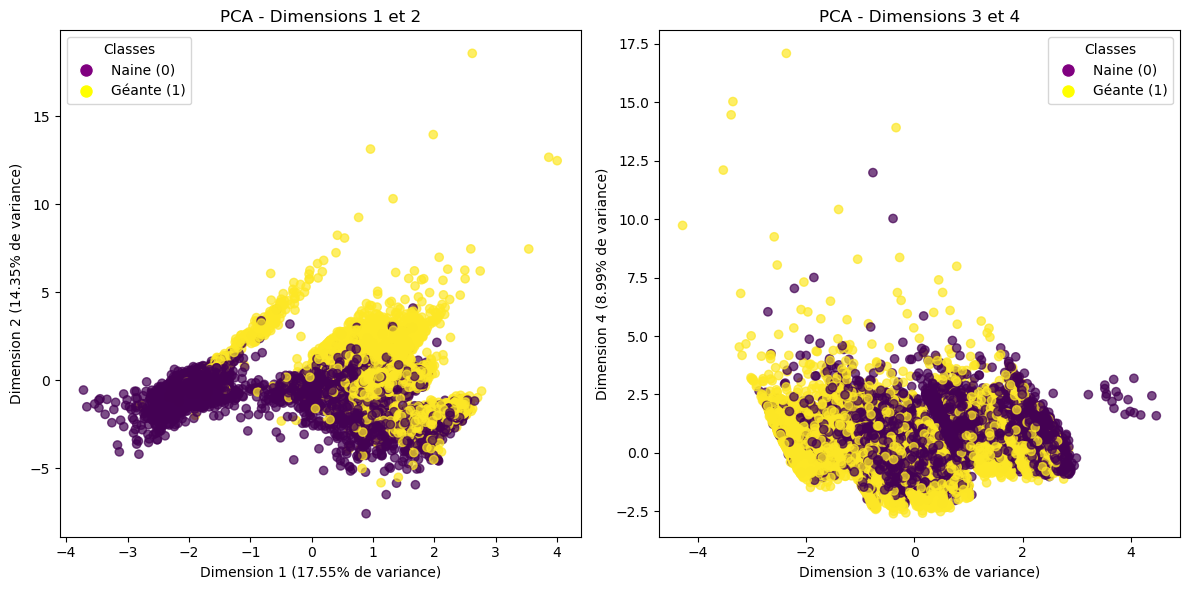

In [22]:
# Visualisation des dimensions principales
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Dimensions 1 et 2
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[0].set_title("PCA - Dimensions 1 et 2")
axes[0].set_xlabel(f"Dimension 1 ({pca.explained_variance_ratio_[0]:.2%} de variance)")
axes[0].set_ylabel(f"Dimension 2 ({pca.explained_variance_ratio_[1]:.2%} de variance)")

# Dimensions 3 et 4
axes[1].scatter(X_pca[:, 2], X_pca[:, 3], c=y, cmap='viridis', alpha=0.7)
axes[1].set_title("PCA - Dimensions 3 et 4")
axes[1].set_xlabel(f"Dimension 3 ({pca.explained_variance_ratio_[2]:.2%} de variance)")
axes[1].set_ylabel(f"Dimension 4 ({pca.explained_variance_ratio_[3]:.2%} de variance)")
axes[1].legend()

# Ajout de la légende pour les deux classes
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Naine (0)'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Géante (1)')]
axes[0].legend(handles=handles, title="Classes")
axes[1].legend(handles=handles, title="Classes")

plt.tight_layout()
plt.show()

### t-SNE

In [20]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

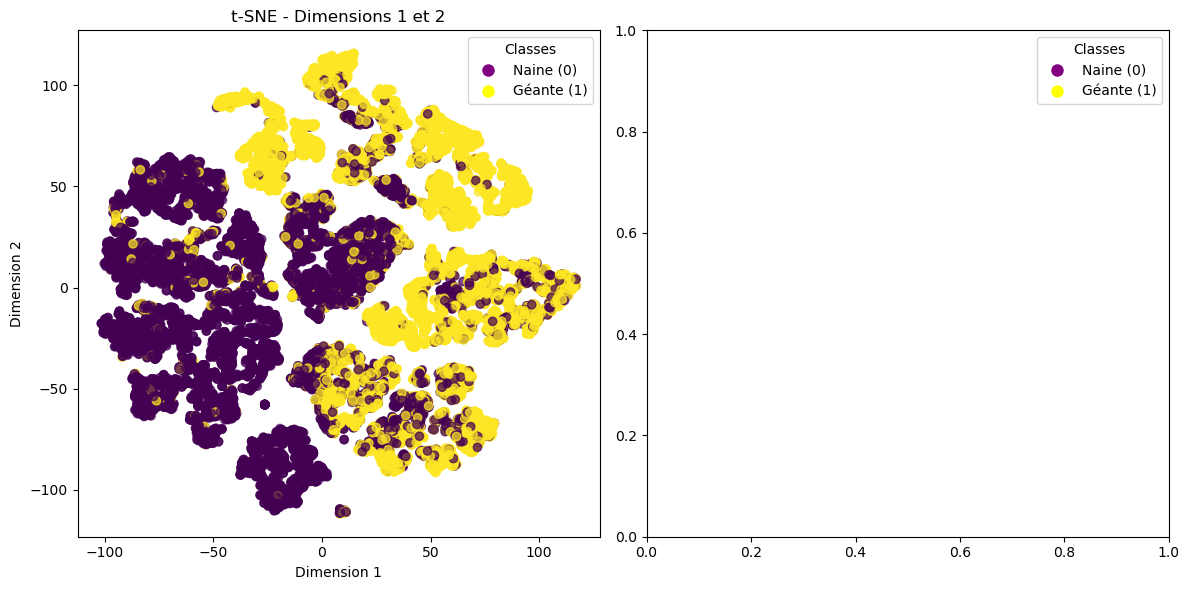

In [23]:
# Créer une figure pour le t-SNE avec deux sous-graphes (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Dimensions 1 et 2
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[0].set_title("t-SNE - Dimensions 1 et 2")
axes[0].set_xlabel("Dimension 1")
axes[0].set_ylabel("Dimension 2")

# Dimensions 3 et 4
# axes[1].scatter(X_tsne[:, 2], X_tsne[:, 3], c=y, cmap='viridis', alpha=0.7)
# axes[1].set_title("t-SNE - Dimensions 3 et 4")
# axes[1].set_xlabel("Dimension 3")
# axes[1].set_ylabel("Dimension 4")

# Ajout de la légende pour les deux classes
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Naine (0)'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Géante (1)')]
axes[0].legend(handles=handles, title="Classes")
axes[1].legend(handles=handles, title="Classes")

plt.tight_layout()
plt.show()

# Classification
## Séparation des données en jeux d’entrainement/validation et test

In [32]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

print(f"Proportion de Géante dans train_val : "
      f"{np.sum(y_train_val) / len(y_train_val):.2%}")
print(f"Proportion Géante de test : "
      f"{np.sum(y_test) / len(y_test):.2%}")

Proportion de Géante dans train_val : 43.64%
Proportion Géante de test : 45.19%


## Régression logistique multinomiale (softmax)
### Modèle

In [35]:
# Initialisez le modèle
baseline_model = LogisticRegression(multi_class='multinomial')

# Entrainez le modèle
baseline_model.fit(X_train_val, y_train_val)

LogisticRegression(multi_class='multinomial')

### Evaluation

In [47]:
# Évaluation sur le jeu d'entraînement/validation
y_train_val_pred = baseline_model.predict(X_train_val)
accuracy_train_val = accuracy_score(y_train_val, y_train_val_pred)
precision_train_val = precision_score(y_train_val, y_train_val_pred, average='weighted')
recall_train_val = recall_score(y_train_val, y_train_val_pred, average='weighted')
f1_train_val = f1_score(y_train_val, y_train_val_pred, average='weighted')

# Évaluation sur le jeu de test
y_test_pred = baseline_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')


# Affichage des résultats
results = {
    'Set': ['Train/Validation', 'Test'],
    'Accuracy': [accuracy_train_val, accuracy_test],
    'Precision': [precision_train_val, precision_test],
    'Recall': [recall_train_val, recall_test],
    'F1 Score': [f1_train_val, f1_test]
}
print(pd.DataFrame(results))

                Set  Accuracy  Precision    Recall  F1 Score
0  Train/Validation  0.888050   0.889676  0.888050  0.888334
1              Test  0.888697   0.890819  0.888697  0.888921


### Cros-validation